In [ ]:
!pip install pennylane torch torchvision

Epoch [10/300], Loss: 0.0565
Epoch [20/300], Loss: 0.0477
Epoch [30/300], Loss: 0.0390
Epoch [40/300], Loss: 0.0287
Epoch [50/300], Loss: 0.0188
Epoch [60/300], Loss: 0.0111
Epoch [70/300], Loss: 0.0061
Epoch [80/300], Loss: 0.0034
Epoch [90/300], Loss: 0.0019
Epoch [100/300], Loss: 0.0011
Epoch [110/300], Loss: 0.0006
Epoch [120/300], Loss: 0.0004
Epoch [130/300], Loss: 0.0003
Epoch [140/300], Loss: 0.0002
Epoch [150/300], Loss: 0.0002
Epoch [160/300], Loss: 0.0002
Epoch [170/300], Loss: 0.0002
Epoch [180/300], Loss: 0.0002
Epoch [190/300], Loss: 0.0002
Epoch [200/300], Loss: 0.0002
Epoch [210/300], Loss: 0.0002
Epoch [220/300], Loss: 0.0002
Epoch [230/300], Loss: 0.0002
Epoch [240/300], Loss: 0.0002
Epoch [250/300], Loss: 0.0002
Epoch [260/300], Loss: 0.0002
Epoch [270/300], Loss: 0.0002
Epoch [280/300], Loss: 0.0002
Epoch [290/300], Loss: 0.0002
Epoch [300/300], Loss: 0.0002


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


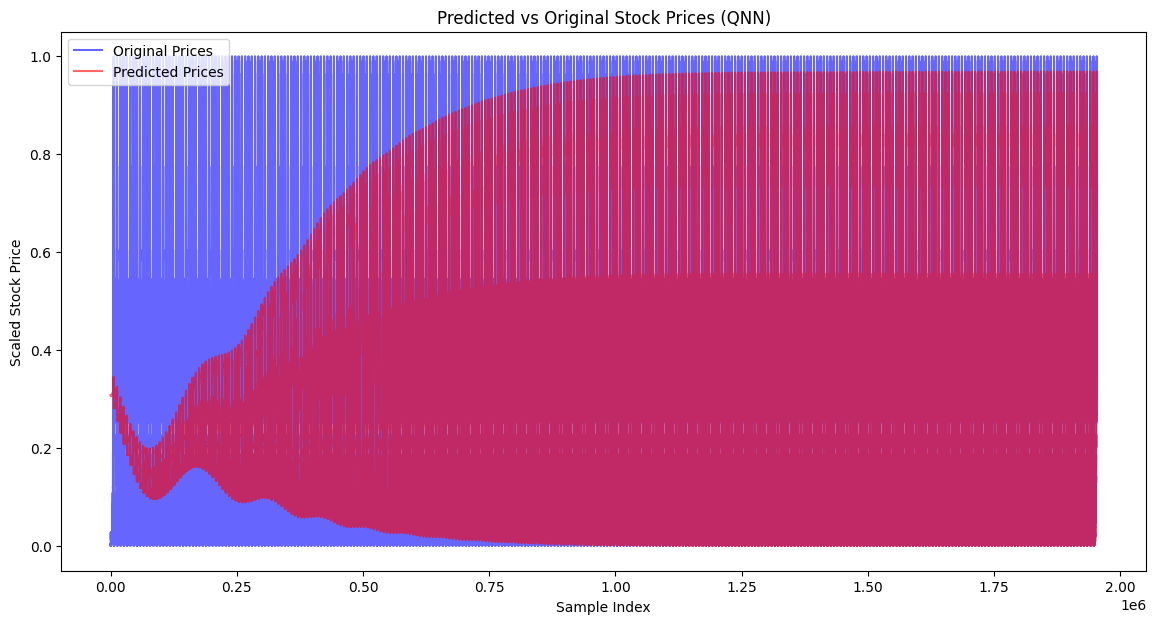

In [ ]:
# -*- coding: utf-8 -*-
"""qnn

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1K3YzqKhKFKc1k2BU2kj4Io9E0yyPtG24
"""

import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define the quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define a quantum node (QNode)
@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    # AngleEmbedding to encode the input features
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    # Parameterized entangler layers
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))

    # Return expectation values
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# Create the QNN layer
weight_shapes = {"weights": (3, n_qubits)}
q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Define the QNN model for stock price prediction
class QNNRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNNRegressionModel, self).__init__()

        self.q_layer = q_layer
        self.fc = nn.Linear(n_qubits, output_size)  # Fully connected layer for output

    def forward(self, x):
        # Get output from the quantum layer
        qnn_out = self.q_layer(x)

        # Fully connected layer to get the final prediction
        output = self.fc(qnn_out)

        return output[:, 0]

# Load your stock data (replace with actual data)
# Example CSV: 'your_stock_data.csv' with columns: Date, Close, etc.
df = pd.read_csv('AMZN.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Scale the target variable (Close Price)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

# Prepare the dataset for training
def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])  # Predict the next price
    return np.array(X), np.array(y)

seq_length = 4  # Use a shorter sequence length for QNN
X, y = create_dataset(scaled_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X).float()  # Shape (num_samples, seq_length, 1)
y_train = torch.tensor(y).float()  # Shape (num_samples, 1)

# Set up the model, loss, and optimizer
input_size = seq_length  # Number of input features (sequence length)
output_size = 1          # Predicted output size

model = QNNRegressionModel(input_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Example training loop
epochs = 300
predictions = []  # List to store predictions
originals = []    # List to store original values

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass
    output = model(X_train)
    loss = criterion(output, y_train)

    # Store predictions and originals for plotting
    predictions.append(output.detach().numpy())
    originals.append(y_train.numpy())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Convert lists to numpy arrays for plotting
predictions = np.vstack(predictions)
originals = np.vstack(originals)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(originals, label='Original Prices', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted Prices', color='red', alpha=0.6)
plt.title('Predicted vs Original Stock Prices (QNN)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(originals, predictions)
print(r2)

0.8738248944282532
